In [458]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 

In [459]:

import pandas as pd

year_range = [2021, 2022, 2023, 2024]

dfs = []

for year in year_range:
    base_url = f"https://www.espn.com/nba/salaries/_/year/{year}"
    
    for i in range(1, 15):
        url = base_url if i == 1 else f"{base_url}/page/{i}"
        tmp = pd.read_html(url)[0]
        tmp["year"] = year
        dfs.append(tmp)

tables = pd.concat(dfs, ignore_index=True)


In [477]:
df = tables.copy().dropna()
df 

,0,1,2,3,year
0,RK,NAME,TEAM,SALARY,2021
1,1,"Stephen Curry, G",Golden State Warriors,"$43,006,362",2021
2,2,"Russell Westbrook, G",Washington Wizards,"$41,358,814",2021
3,3,"Chris Paul, G",Phoenix Suns,"$41,358,814",2021
4,4,"James Harden, G",Brooklyn Nets,"$41,254,920",2021
...,...,...,...,...,...
2262,473,"Taj Gibson, F",Detroit Pistons,"$348,225",2024
2263,474,"Onuralp Bitim, SF",Chicago Bulls,"$334,582",2024
2264,475,"Javon Freeman-Liberty, G",Toronto Raptors,"$289,542",2024
2265,RK,NAME,TEAM,SALARY,2024


In [ ]:
# Turn SALARY into int
s = df[3].astype(str).str.replace(r"[$,]", "", regex=True).str.strip()
df[3] = pd.to_numeric(s, errors="coerce").astype("Int64")  # nullable int
df.dropna(inplace=True)


In [478]:
names_df = pd.DataFrame({"names":df[df.columns[1]]})

allowed = set(names_df["names"].unique())  
allowed_df = pd.DataFrame(allowed)

df_filtered = names_df[names_df["names"].isin(allowed)]

assert len(names_df) == len(df_filtered)
allowed_df 

,0
0,"Allonzo Trier, G"
1,"Dennis Smith Jr., PG"
2,"Furkan Korkmaz, SG"
3,"Maurice Harkless, SF"
4,"Tyrell Terry, PG"
...,...
761,"Thaddeus Young, F"
762,"Tyrese Maxey, G"
763,"T.J. Leaf, PF"
764,"James Wiseman, C"


In [463]:
allowed_df.to_csv("names_salaries_tmp.csv", index=False)


Text(0, 0.5, 'Salary (1e7 $)')

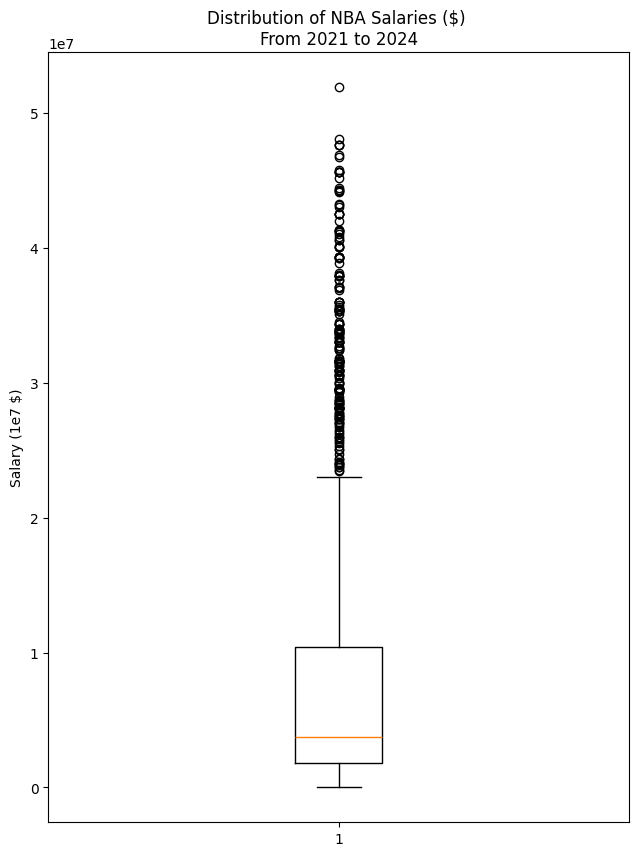

In [464]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 10))

ax.boxplot(df[3])
ax.set_title("Distribution of NBA Salaries ($) \nFrom 2021 to 2024")
ax.set_ylabel("Salary (1e7 $)")

In [465]:
import pandas as pd
import re
import unicodedata

_SUFFIXES = {"jr", "sr", "ii", "iii", "iv", "v"}

def norm_name(raw: str) -> str:
    s = unicodedata.normalize("NFKD", str(raw))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))  # strip accents
    s = s.lower().strip()

    # normalize apostrophes / punctuation
    s = s.replace("’", "'")
    s = re.sub(r"[.\(\)]", "", s)

    # hyphens -> space, multiple spaces -> single
    s = s.replace("-", " ")
    s = re.sub(r"\s+", " ", s).strip()

    # remove commas etc
    s = s.replace(",", "")

    # drop suffixes at end
    parts = s.split()
    while parts and parts[-1] in _SUFFIXES:
        parts.pop()

    # normalize common "deandre"/"de'andre" patterns by removing apostrophe
    s = " ".join(parts).replace("de'andre", "deandre").replace("d'angelo", "dangelo")

    return s

dfA = pd.read_csv("names_advanced_tmp.csv")   # has Player, Player-additional
dfB = pd.read_csv("names_salaries_tmp.csv")   # has something like Name column with "Stephen Curry, G"

# adjust these column names if needed:
colA_player = "Player"
colA_addl   = "Player-additional"
colB_name   = "0"

# Build normalized keys
dfA["_key"] = dfA[colA_player].map(norm_name)
dfB["_player_only"] = dfB[colB_name].astype(str).str.split(",").str[0].str.strip()
dfB["_key"] = dfB["_player_only"].map(norm_name)

# Lookup: normalized name -> list[(Player, Player-additional)]
a_lookup = (
    dfA.groupby("_key")[[colA_player, colA_addl]]
       .apply(lambda g: list(map(tuple, g.to_numpy())))
       .to_dict()
)


In [466]:
mapping = {}
missing = []

for bval, k in zip(dfB[colB_name], dfB["_key"]):
    if k in a_lookup:
        mapping[bval] = a_lookup[k]
    else:
        missing.append(bval)

print("matches:", len(mapping), "missing:", len(missing))
mapping

matches: 565 missing: 200


{'Dennis Smith Jr., PG': [('Dennis Smith Jr.', 'smithde03'),
  ('Dennis Smith Jr.', 'smithde03'),
  ('Dennis Smith Jr.', 'smithde03')],
 'Furkan Korkmaz, SG': [('Furkan Korkmaz', 'korkmfu01'),
  ('Furkan Korkmaz', 'korkmfu01')],
 'Maurice Harkless, SF': [('Maurice Harkless', 'harklma01'),
  ('Maurice Harkless', 'harklma01'),
  ('Maurice Harkless', 'harklma01')],
 'Tyrell Terry, PG': [('Tyrell Terry', 'terryty01'),
  ('Tyrell Terry', 'terryty01')],
 'Trae Young, G': [('Trae Young', 'youngtr01'), ('Trae Young', 'youngtr01')],
 'Clint Capela, C': [('Clint Capela', 'capelca01'),
  ('Clint Capela', 'capelca01')],
 'Al-Farouq Aminu, SF': [('Al-Farouq Aminu', 'aminual01'),
  ('Al-Farouq Aminu', 'aminual01')],
 'Josh Giddey, G': [('Josh Giddey', 'giddejo01')],
 'Isaiah Roby, PF': [('Isaiah Roby', 'robyis01'), ('Isaiah Roby', 'robyis01')],
 'James Harden, G': [('James Harden', 'hardeja01'),
  ('James Harden', 'hardeja01'),
  ('James Harden', 'hardeja01'),
  ('James Harden', 'hardeja01')],
 'Jar

In [467]:
for i in missing:
    print(i) 

Allonzo Trier, G
Dragan Bender, F
Mouhamed Gueye, F
Jalen Duren, C
Josh Gray, G
Jonah Bolden, PF
Dyson Daniels, G
Ochai Agbaji, G
Christian Braun, G
Ky Bowman, G
Courtney Lee, G
GG Jackson, F
Jaylin Williams, F
Julian Champagnie, F
Chris Clemons, G
Antonio Blakeney, G
Tyrese Martin, G
Sidy Cissoko, G
Alex Abrines, G
Marcin Gortat, C
Isaiah Whitehead, G
E.J. Liddell, F
Jason Smith, F
Brandon Miller, F
Javon Freeman-Liberty, G
Omer Asik, C
Ike Anigbogu, C
Wade Baldwin IV, G
Omri Casspi, F
Dairis Bertans, G
Nate Williams, G
Blake Wesley, G
Jake LaRavia, F
Marcus Sasser, G
AJ Griffin, F
Scoot Henderson, G
MarShon Brooks, G
Chandler Parsons, SF
Isaiah Taylor, G
Julyan Stone, G
Ryan Rollins, G
TyTy Washington Jr., G
Nikola Mirotic, F
Ben Moore, F
Tyler Lydon, F
Taylor Hendricks, F
Amen Thompson, G
Mark Williams, C
Tyreke Evans, G
Rodney Purvis, G
Nick Young, G
Zhou Qi, C
A.J. Lawson, G
Xavier Cooks, G
Jarace Walker, F
Jaime Jaquez Jr., F
Nick Smith Jr., G
Isaiah Canaan, G
Gradey Dick, G
Stan

In [468]:
import hashlib

df["Player"] = df[1].map(lambda n: (mapping.get(n) or [(None, None)])[0][0])
df["Player-additional"] = df[1].map(lambda n: (mapping.get(n) or [(None, None)])[0][1])

In [469]:
df = df[["Player", "Player-additional", 2, 3, "year"]]
df = df.rename(columns={2:"Team", 3: "Salary", "year":"Year"})

df 

,Player,Player-additional,Team,Salary,Year
1,Stephen Curry,curryst01,Golden State Warriors,43006362,2021
2,Russell Westbrook,westbru01,Washington Wizards,41358814,2021
3,Chris Paul,paulch01,Phoenix Suns,41358814,2021
4,James Harden,hardeja01,Brooklyn Nets,41254920,2021
5,John Wall,walljo01,Houston Rockets,41254920,2021
...,...,...,...,...,...
2260,Patty Mills,millspa02,Miami Heat,475908,2024
2261,None,None,San Antonio Spurs,455620,2024
2262,Taj Gibson,gibsota01,Detroit Pistons,348225,2024
2263,None,None,Chicago Bulls,334582,2024


In [470]:
team_to_tm = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Hornets": "CHO",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Lakers": "LAL",
    "LA Clippers": "LAC",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS",
}


In [471]:
df["Tm"] = df["Team"].map(team_to_tm) 
df = df.drop("Team", axis=1)

In [472]:
df = df[["Player", "Player-additional", "Tm", "Salary", "Year"]]
df.sort_values(["Player", "Year"])

,Player,Player-additional,Tm,Salary,Year
67,Aaron Gordon,gordoaa01,DEN,18136364,2021
694,Aaron Gordon,gordoaa01,DEN,16409091,2022
1228,Aaron Gordon,gordoaa01,DEN,19690909,2023
1813,Aaron Gordon,gordoaa01,DEN,22266182,2024
342,Aaron Holiday,holidaa01,IND,2345640,2021
...,...,...,...,...,...
2256,None,None,DET,538460,2024
2257,None,None,UTA,500000,2024
2261,None,None,SAS,455620,2024
2263,None,None,CHI,334582,2024


In [473]:
df = df.dropna()
df 

,Player,Player-additional,Tm,Salary,Year
1,Stephen Curry,curryst01,GSW,43006362,2021
2,Russell Westbrook,westbru01,WAS,41358814,2021
3,Chris Paul,paulch01,PHO,41358814,2021
4,James Harden,hardeja01,BRK,41254920,2021
5,John Wall,walljo01,HOU,41254920,2021
...,...,...,...,...,...
2253,Trent Forrest,forretr01,ATL,553151,2024
2254,Shake Milton,miltosh01,NYK,552938,2024
2258,Darius Bazley,bazleda01,UTA,500000,2024
2260,Patty Mills,millspa02,MIA,475908,2024


In [474]:
df.to_csv("clean/nba_salaries_2021_to_2025.csv", index=False)